In [63]:
#1. IMPORTING PACKAGES AND LIBRARIES
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.img_tiles import OSM
from cartopy.io.img_tiles import GoogleTiles as moa
from cycler import cycler
import scipy
import seaborn as sns

import glob
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xarray as xr
import pyproj
import osr
import datetime
import subprocess
import shutil
import numpy as np
from ipywidgets import interact
import pandas as pd
import pickle
from scipy.signal import savgol_filter
import time
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot


#own libary
import nsidc 

from functions_pmrs import loadCM
from functions_pmrs import applyshift
from functions_pmrs import calculateQR
from functions_pmrs import probability
from functions_pmrs import NQT


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
#SELECT BOUNDS AND START / END DATES
bounds = [( -19., 20.),
          (-11., 27.),
         ]

# start_date = datetim.datetime(2002, 5, 29) # Start of the AMSR-E period
# start_date = datetime.datetime(2004, 1, 1) # date after data recovery
# end_date = datetime.datetime(2009, 12, 31)  # only a few days to make a demonstration
# end_date = datetime.datetime(2004, 6, 30)  # use this end date to cover the whole AMSR-E period.
# end_date = datetime.datetime(2002, 1, 2)

#---------------------------#---------------------------#---------------------------#---------------------------#

#Select set of POI's to use

# points = pd.read_csv('poizambeziplain.csv')   #Kalabo (weinig goede resultaten)
points = pd.read_csv('poi_senaga.csv')
# points = pd.read_csv('POIs_RE_3p.csv')


#adjust according to number of points in POI's
points_interest = [(points.xcoord[0],points.ycoord[0]),
                   (points.xcoord[1],points.ycoord[1])]
#                    (points.xcoord[2],points.ycoord[2]),
#                    (points.xcoord[3],points.ycoord[3]),
#                    (points.xcoord[4],points.ycoord[4])]
#                    (points.xcoord[5],points.ycoord[5])]
#                    (points.xcoord[6],points.ycoord[6]) 


# Download discharge data, no adjustment 
# dQ = pd.read_csv('ZAMBEZIDISCHARGE.csv',sep=';',parse_dates=['DATE'],index_col = ['DATE'],na_filter=True)
dQ = pd.read_csv('ZAMBEZIDISCHARGE.csv',sep=';',na_filter=True) #,parse_dates=['DATE'],index_col = ['DATE']
dQ['Date'] = pd.to_datetime(dQ['Date'])



#---------------------------#---------------------------#---------------------------#---------------------------#

# DOWNLOAD THE CORRECT DATA
# This cell calls the right download and "glues" the years together. 

fns=None

year = 2009  #change year to select specific year to see [2002-2011]

# 25 km resolution PMSR DATA
# fns = glob.glob(f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/25km36ghz/NSIDC_Test_{year}.nc')
#select this next one for full period data string (whole AMSR period)
fns = glob.glob('/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/25km36ghz/*.nc') # select this line to get the whole AMSR-E period

# 3.125 km resolution PMSR DATA

# fns = glob.glob(f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/3km36ghz/NSIDC_Test_{year}.nc')
#select this next one for full period data string (whole AMSR period)
# fns = glob.glob('/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/3km36ghz/*.nc') # select this line to get the whole AMSR-E period

fns.sort()
ds = xr.open_mfdataset(fns[0:10])

#---------------------------#---------------------------#---------------------------#---------------------------#

# Discharge data location
# location = 'Kalabo'  
location = 'Senanga'
# location = 'Lukulu'


#---------------------------#---------------------------#---------------------------#---------------------------#


# TRANSFORMING, NO ADJUSTMENT NEEDED
proj4str = '+proj=cea +lat_0=0 +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m'
# we define a projection object for lat-lon WGS84 (EPSG code 4326)
proj_out = pyproj.Proj(init='epsg:4326')
# we define a projection object for the projection used in the downloaded grids.
proj_in = pyproj.Proj(proj4str)

# here we convert the coordinates in lat-lon into the coordinate system of the downloaded grids.
bounds_xy = nsidc.proj_coords(bounds, proj_out, proj_in)
points_xy = nsidc.proj_coords(points_interest, proj_out, proj_in)
points_x, points_y = zip(*points_xy)

#---------------------------#---------------------------#---------------------------#---------------------------#
sns.set()

<ipython-input-64-22362dd2db26>:59: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds = xr.open_mfdataset(fns[0:10])
/Users/oscarkeunen/opt/anaconda3/envs/afstuderen/lib/python3.8/site-packages/xarray/backends/api.py:926: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  combined = auto_combine(
/Users/oscarkeunen/opt/anaconda3/envs/afstuderen/lib/python3.8/site-packages/pyproj/crs.py:

In [65]:

shift=15
rollingvalue =6
selection= 5 # < number of months to be choosen
plot = 0


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.columns = ['POI1', 'POI4']


                         QuantReg Regression Results                          
Dep. Variable:                   POI4   Pseudo R-squared:               0.7356
Model:                       QuantReg   Bandwidth:                    0.007457
Method:                 Least Squares   Sparsity:                      0.03522
Date:                Mon, 16 Mar 2020   No. Observations:                  962
Time:                        11:55:17   Df Residuals:                      960
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0097      0.013     -0.753      0.452      -0.035       0.016
POI1           1.0213      0.012     83.696      0.000       0.997       1.045


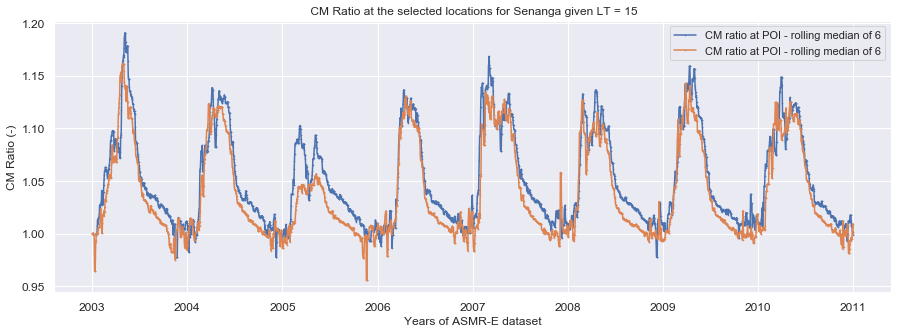

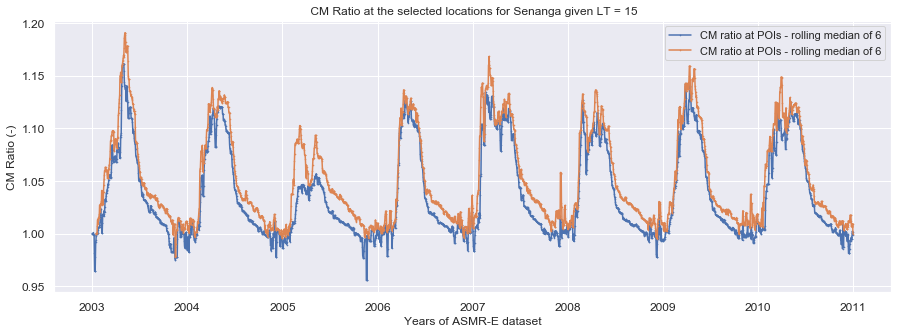

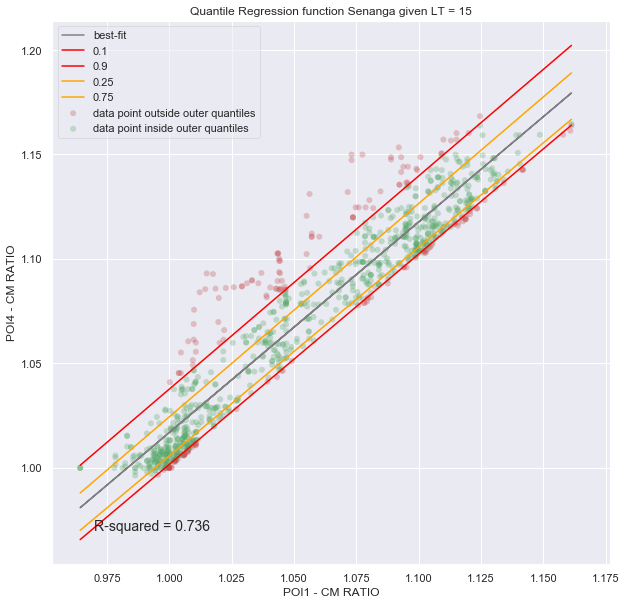

In [67]:
df = loadCM(points_xy,ds, rollingvalue)
plot=1
df = applyshift(df,rollingvalue,shift,plot)

df_nqt = NQT(df,plot, shift, location, rollingvalue)


fits,res = calculateQR(df_nqt,selection,plot,shift,location)
plot =0
pred = probability(df, fits, plot, shift,location)

obs = df.POI4.values.copy()
threshold =1.05

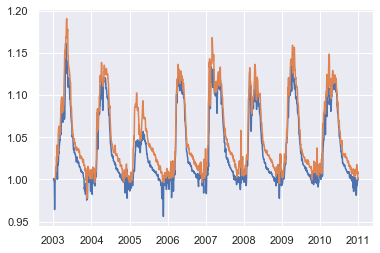

In [62]:
from sklearn import preprocessing
df_temp = np.sort(df,axis=1)
quantile_transformer = preprocessing.QuantileTransformer(output_distribution='uniform',copy=True)


X_trans = quantile_transformer.fit_transform(df_temp)
X_trans = quantile_transformer.inverse_transform(X_trans)


df_qt =pd.DataFrame({'POI1': X_trans[:, 0], 'POI4': X_trans[:, 1]},index =df.index) 
plt.plot(df_qt)

                POI1      POI4
2003-01-01  1.000000  1.000000
2003-01-02  1.000000  1.000000
2003-01-03  1.000000  1.000000
2003-01-04  1.000000  1.000000
2003-01-05  1.000000  1.000000
...              ...       ...
2010-12-27  1.007560  0.995371
2010-12-28  1.006230  1.000878
2010-12-29  1.002401  1.006386
2010-12-30  1.001748  1.009612
2010-12-31  0.999074  1.000000

[2922 rows x 2 columns]


                         QuantReg Regression Results                          
Dep. Variable:                   POI4   Pseudo R-squared:               0.7357
Model:                       QuantReg   Bandwidth:                    0.007446
Method:                 Least Squares   Sparsity:                      0.03526
Date:                Mon, 16 Mar 2020   No. Observations:                  962
Time:                        11:48:44   Df Residuals:                      960
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0102      0.013     -0.790      0.430      -0.035       0.015
POI1           1.0218      0.012     83.659      0.000       0.998       1.046


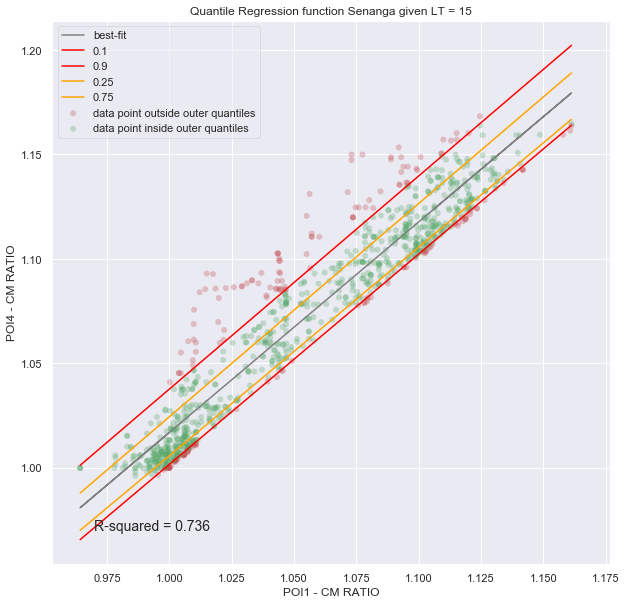

In [60]:
fits,res = calculateQR(df_qt,selection,plot,shift,location)
